## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.ensemble import RandomForestClassifier

## Import cleaned dataset

In [2]:
df = pd.read_csv('../Data/Cleaned Data/Subreddit_travel_clean.csv')

In [3]:
df.shape

(4400, 2)

In [4]:
df.sample(5)

,subreddit,lemmatized_text
3411,Europetravel,urgent emergency travel question hello everyon...
2408,Europetravel,best european beach vacation for solo female t...
4284,Europetravel,london and paris early march any tip for our v...
1247,VisitingHawaii,where can report illegal airbnb hello all visi...
4359,Europetravel,question regard travel south france summer sho...


In [5]:
df.subreddit.unique()

array(['VisitingHawaii', 'Europetravel'], dtype=object)

## Baseline Model Score

In [6]:
df.subreddit.value_counts(normalize=True)

subreddit
VisitingHawaii    0.541591
Europetravel      0.458409
Name: proportion, dtype: float64

## Modeling and Evaluation

### Preprocessing

In [7]:
df['subreddit'] = df['subreddit'].map({'VisitingHawaii':0, 'Europetravel':1})

In [8]:
X = df['lemmatized_text']
y = df['subreddit']
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=2024)

In [9]:
X.shape

(4400,)

### Model 1. Logistic Regression

In [10]:
pgrid = {
    'cvec__stop_words':['english'],
    'cvec__ngram_range':[(1,1),(1,2)],
    
    'lr__penalty': ['l1', 'l2'],
    'lr__C': np.logspace(-2, 0, 100)
}

StandardScaler
pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('lr', LogisticRegression(solver='liblinear'))
])

gs = GridSearchCV(pipe, param_grid=pgrid, n_jobs=5)

In [11]:
%%time
gs.fit(X_train,y_train)

CPU times: user 7.44 s, sys: 1.61 s, total: 9.06 s
Wall time: 4min 28s


GridSearchCV(estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('lr',
                                        LogisticRegression(solver='liblinear'))]),
             n_jobs=5,
             param_grid={'cvec__ngram_range': [(1, 1), (1, 2)],
                         'cvec__stop_words': ['english'],
                         'lr__C': array([0.01      , 0.01047616, 0.01097499, 0.01149757, 0.01204504,
       0.01261857, 0.01321941, 0.01384886, 0.01450829, 0.01519911,
       0.01592283, 0.01668101, 0.0174752...
       0.20565123, 0.21544347, 0.22570197, 0.23644894, 0.24770764,
       0.25950242, 0.27185882, 0.28480359, 0.29836472, 0.31257158,
       0.32745492, 0.34304693, 0.35938137, 0.37649358, 0.39442061,
       0.41320124, 0.43287613, 0.45348785, 0.47508102, 0.49770236,
       0.52140083, 0.54622772, 0.57223677, 0.59948425, 0.62802914,
       0.65793322, 0.68926121, 0.7220809 , 0.75646333, 0.7924829 ,
       0.83021757, 0.869749  , 0.91116276, 0.95454846, 1.        ]),
                         'lr__penalty': ['l1', 'l2']})

In [12]:
gs.best_params_

{'cvec__ngram_range': (1, 1),
 'cvec__stop_words': 'english',
 'lr__C': 0.35938136638046275,
 'lr__penalty': 'l2'}

In [13]:
gs.score(X_train, y_train)

1.0

In [14]:
gs.score(X_test,y_test)

0.9781818181818182

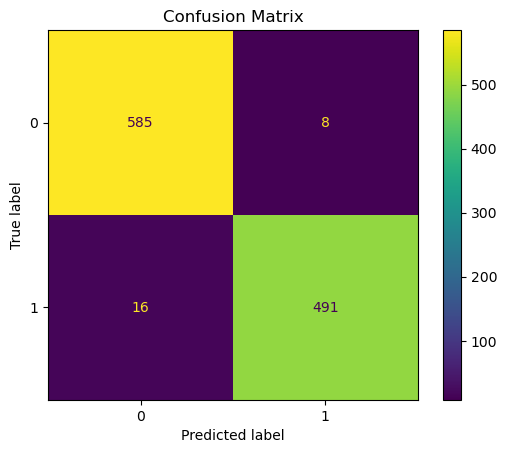

In [15]:
conf_matrix = confusion_matrix(y_test, gs.predict(X_test))

# Display Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=gs.classes_)
disp.plot()
plt.title('Confusion Matrix')
plt.show()

### Model 2. Multinomial Naive Bayes

In [46]:
params = {
    'tvec__stop_words': [None, 'english'],
    'tvec__min_df': [1, 2, 3, 4, 5],
    'tvec__ngram_range': [(1, 1), (1, 2)],
    'tvec__max_features': [100, 200, 500, 1500, 2000, None]
}


pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('nb', MultinomialNB())
])


gs_mnb = GridSearchCV(pipe, params, cv=5, n_jobs=5)

In [47]:
%%time
gs_mnb.fit(X_train, y_train)

CPU times: user 2.48 s, sys: 615 ms, total: 3.09 s
Wall time: 1min 14s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('nb', MultinomialNB())]),
             n_jobs=5,
             param_grid={'tvec__max_features': [100, 200, 500, 1500, 2000,
                                                None],
                         'tvec__min_df': [1, 2, 3, 4, 5],
                         'tvec__ngram_range': [(1, 1), (1, 2)],
                         'tvec__stop_words': [None, 'english']})

In [48]:
gs_mnb.best_params_

{'tvec__max_features': None,
 'tvec__min_df': 5,
 'tvec__ngram_range': (1, 2),
 'tvec__stop_words': 'english'}

In [49]:
gs_mnb.score(X_train, y_train)

0.9918181818181818

In [50]:
gs_mnb.score(X_test, y_test)

0.9772727272727273

In [52]:
y_hat_mnb = gs_mnb.predict(X_test)

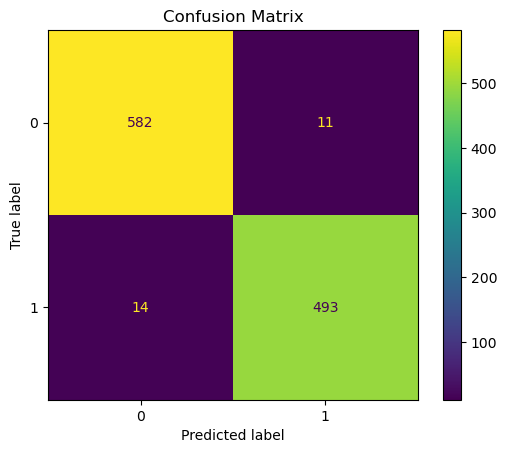

In [53]:
conf_matrix_mnb = confusion_matrix(y_test,y_hat_mnb)

# Display Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_mnb, display_labels=gs.classes_)
disp.plot()
plt.title('Confusion Matrix')
plt.show()

### Model 3. Random Forest Classification

In [23]:
params = {
    'tvec__stop_words': [None, 'english'],
    'tvec__min_df': [1, 2, 3, 4, 5],
    'tvec__ngram_range': [(1, 1), (1, 2)],
    'tvec__max_features': [100, 200, 500, 1500, 2000, None],
    'rf__max_depth':[5,10,20,30],
    'rf__min_samples_split': list(range(2, 12)), #Minimum number of samples required to split an internal node
    'rf__min_samples_leaf': list(range(1, 5)),  #Minimum number of samples required to be at a leaf node
    'rf__oob_score': [True]
    
}


pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('rf', RandomForestClassifier())
])


rs = RandomizedSearchCV(pipe, params, n_iter = 1_000, cv=5, n_jobs=-1, scoring='accuracy',random_state=2024)

In [24]:
%%time
rs.fit(X_train,y_train)

CPU times: user 21.4 s, sys: 4.18 s, total: 25.6 s
Wall time: 19min 59s


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                             ('rf', RandomForestClassifier())]),
                   n_iter=1000, n_jobs=-1,
                   param_distributions={'rf__max_depth': [5, 10, 20, 30],
                                        'rf__min_samples_leaf': [1, 2, 3, 4],
                                        'rf__min_samples_split': [2, 3, 4, 5, 6,
                                                                  7, 8, 9, 10,
                                                                  11],
                                        'rf__oob_score': [True],
                                        'tvec__max_features': [100, 200, 500,
                                                               1500, 2000,
                                                               None],
                                        'tvec__min_df': [1, 2, 3, 4, 5],
                                        'tvec__ngram_range': [(1, 1), (1, 2)],
                                        'tvec__stop_words': [None, 'english']},
                   random_state=2024, scoring='accuracy')

In [25]:
rs.score(X_train,y_train)

0.99

In [26]:
rs.score(X_test, y_test)

0.9609090909090909

In [27]:
rs.best_params_

{'tvec__stop_words': None,
 'tvec__ngram_range': (1, 2),
 'tvec__min_df': 1,
 'tvec__max_features': 1500,
 'rf__oob_score': True,
 'rf__min_samples_split': 3,
 'rf__min_samples_leaf': 1,
 'rf__max_depth': 30}

In [42]:
y_hat_rs = rs.predict(X_test)

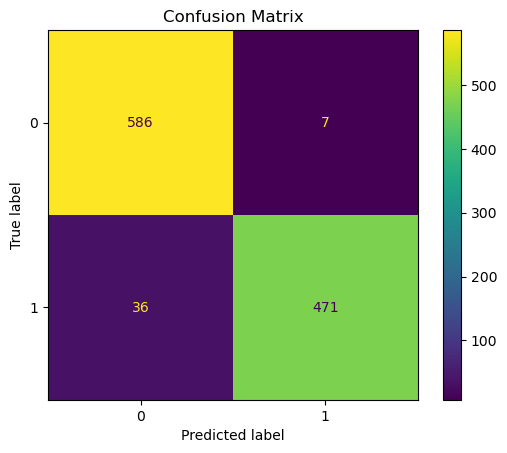

In [54]:
conf_matrix_rs = confusion_matrix(y_test,y_hat_rs)

# Display Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_rs, display_labels=gs.classes_)
disp.plot()
plt.title('Confusion Matrix')
plt.show()

### Model 4. SVC - count vectorizer

In [55]:
params = [
    {   
        'cvec__stop_words':['english',None],
        'cvec__ngram_range':[(1,1),(1,2)],
        'cvec__max_features':[100,200,500,1000,2000],
        'svc__C': np.linspace(0.001,5,100),
        'svc__kernel':['rbf']
    }
]

pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('svc', SVC(max_iter=10_000))
])


gs_svcc = GridSearchCV(pipe,params,cv=5,n_jobs=-1, scoring='accuracy', error_score='raise')

In [56]:
%%time
# Fit on training data.
gs_svcc.fit(X_train,y_train)

CPU times: user 47.5 s, sys: 28.3 s, total: 1min 15s
Wall time: 1h 1min 17s


GridSearchCV(cv=5, error_score='raise',
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('svc', SVC(max_iter=10000))]),
             n_jobs=-1,
             param_grid=[{'cvec__max_features': [100, 200, 500, 1000, 2000],
                          'cvec__ngram_range': [(1, 1), (1, 2)],
                          'cvec__stop_words': ['english', None],
                          'svc__C': array([1.00000000e-03, 5.14949495e-02, 1.01989899e-01, 1.52484848e-01,
       2.02979798e-01,...
       3.83861616e+00, 3.88911111e+00, 3.93960606e+00, 3.99010101e+00,
       4.04059596e+00, 4.09109091e+00, 4.14158586e+00, 4.19208081e+00,
       4.24257576e+00, 4.29307071e+00, 4.34356566e+00, 4.39406061e+00,
       4.44455556e+00, 4.49505051e+00, 4.54554545e+00, 4.59604040e+00,
       4.64653535e+00, 4.69703030e+00, 4.74752525e+00, 4.79802020e+00,
       4.84851515e+00, 4.89901010e+00, 4.94950505e+00, 5.00000000e+00]),
                          'svc__kernel': ['rbf']}],
             scoring='accuracy')

In [57]:
gs_svcc.best_params_

{'cvec__max_features': 2000,
 'cvec__ngram_range': (1, 2),
 'cvec__stop_words': None,
 'svc__C': 4.4950505050505045,
 'svc__kernel': 'rbf'}

In [58]:
gs_svcc.score(X_train,y_train)

0.9906060606060606

In [59]:
gs_svcc.score(X_test,y_test)

0.9545454545454546

In [60]:
y_hat_svcc = gs_svcc.predict(X_test)

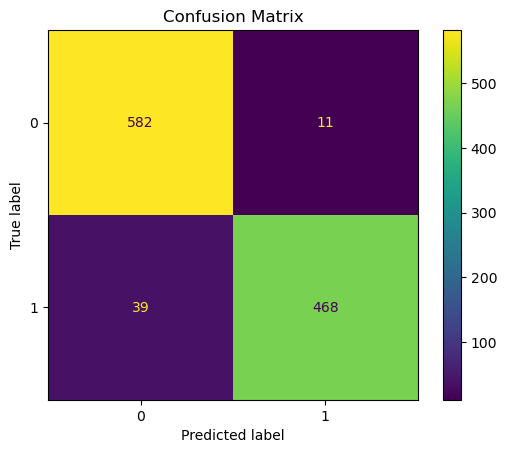

In [61]:
conf_matrix_svcc = confusion_matrix(y_test,y_hat_svcc)

# Display Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_svcc, display_labels=gs.classes_)
disp.plot()
plt.title('Confusion Matrix')
plt.show()

### Model 5. SVC - tfid Vectorizer

In [62]:
params = [
    {   'tvec__stop_words': [None, 'english'],
        'tvec__ngram_range': [(1,1),(1, 2)],
        'tvec__max_features': [100,200,500,1000,2000],
        'svc__C': np.linspace(0.001,5,100),
        'svc__kernel':['rbf']
    }
]

pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('svc', SVC(max_iter=10000, random_state = 2024))
])


gs_svct = GridSearchCV(pipe,params,cv=5,n_jobs=-1, scoring='accuracy', error_score='raise')

In [63]:
%%time
gs_svct.fit(X_train,y_train)

CPU times: user 40.2 s, sys: 8.21 s, total: 48.4 s
Wall time: 1h 9min 52s


GridSearchCV(cv=5, error_score='raise',
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('svc',
                                        SVC(max_iter=10000,
                                            random_state=2024))]),
             n_jobs=-1,
             param_grid=[{'svc__C': array([1.00000000e-03, 5.14949495e-02, 1.01989899e-01, 1.52484848e-01,
       2.02979798e-01, 2.53474747e-01, 3.03969697e-01, 3.54464646e-01,
       4.04959596e-01, 4.55454545e-01, 5.05949495e-01, 5.56444...
       4.24257576e+00, 4.29307071e+00, 4.34356566e+00, 4.39406061e+00,
       4.44455556e+00, 4.49505051e+00, 4.54554545e+00, 4.59604040e+00,
       4.64653535e+00, 4.69703030e+00, 4.74752525e+00, 4.79802020e+00,
       4.84851515e+00, 4.89901010e+00, 4.94950505e+00, 5.00000000e+00]),
                          'svc__kernel': ['rbf'],
                          'tvec__max_features': [100, 200, 500, 1000, 2000],
                          'tvec__ngram_range': [(1, 1), (1, 2)],
                          'tvec__stop_words': [None, 'english']}],
             scoring='accuracy')

In [64]:
gs_svct.best_params_

{'svc__C': 1.2128787878787877,
 'svc__kernel': 'rbf',
 'tvec__max_features': 2000,
 'tvec__ngram_range': (1, 2),
 'tvec__stop_words': 'english'}

In [65]:
gs_svct.score(X_train,y_train)

1.0

In [66]:
gs_svct.score(X_test,y_test)

0.9818181818181818

In [67]:
y_hat_svct = gs_svct.predict(X_test)

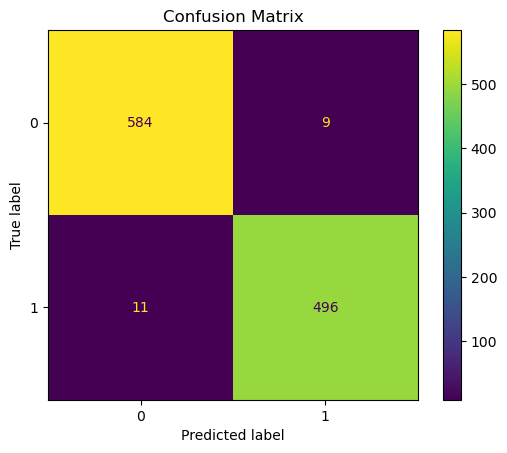

In [68]:
conf_matrix_svct = confusion_matrix(y_test,y_hat_svct)

# Display Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_svct, display_labels=gs.classes_)
disp.plot()
plt.title('Confusion Matrix')
plt.show()